# Analysis Exp. 1 - obstacle avoidance

In [1]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats
import env_params

# Data management
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch
import dataframe_image as dfi

# Suppress pandas future-warning about categorical dtypes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Load the parameters of the unity environment.
import env_params
from env_params import HALLWAY_DIMS as hw_dims
from env_params import get_hallway_layouts, Boxes

hallways = env_params.get_hallway_layouts()
segmentLength = hw_dims['segmentLength']
hwLength = len(hallways)*hw_dims['segmentLength']
box_locations = env_params.BOX_LOCATIONS

## Load data

In [3]:
# Specify which data to load
data_dir = data_processing.DATA_DIR_EXP1
subjects = data_processing.SUBJECTS_EXP1
data_keys = ['TrialConfigRecord','EngineDataRecord'] # which type of data to load

# Get Filenames (no calibration performed in exp1, so clbr_filenames returned empty).
exp_filenames, clbr_filenames = data_processing.get_filenames(data_dir = data_dir,
                                                              subjects=subjects, 
                                                              data_keys = data_keys) 

# Load raw data 
exp_data = data_processing.load_data_from_filenames(exp_filenames)

# Process into useful format
data_processing.reformat_data(exp_data,
                              convert_quaternions=False,
                              expand_columns=['XRHeadPos', 'XROriginPos'])

# Copy the separate dataframes
eng_data = exp_data['EngineDataRecord'].copy() # Timeseries data of the unity game engine (head position, button events, etc.)
trc_data = exp_data['TrialConfigRecord'].copy() # Config. data saved after each trial: (experimental conditions, trial duration, etc.)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:44<00:00, 52.47s/it]


### Remove invalid data

Some data files contain frames with wrong timestamp (increasing with respect to the previous one). This is because in some cases the writing of the previous datafile was not finished before the next trial was started. The faulty frames can be easily identified using the time stamps.

The valid frames adhere to 3 criteria:
- the Timestamps are increasing
- there is not a large gap between timestamps (long frame duration)
- the head position is inside the correct hallway that was used for the current trial (only implemented as sanity check)

In [4]:
def detect_invalid_frames(data, verbose=True, max_frame_duration=1., drop_first_and_last=5, invalid_window=10,):
    """Sort data, find incongruent timestamps in the engine data and mark frames as invalid. 
    Note: performs in-place operations on the input dataframe
    returns: trial-indexed dataframe indicating which trials contain invalid frames.
    """
    # Mark as invalid if timestamp is not larger than previous frame
    data['InvalidTimeStamp'] = data.TimeStamp < data.groupby('TrialIdentifier').TimeStamp.cummax()
    
    # Sort the data using the timestamps
    data.sort_values('TimeStamp', inplace=True)
    data.reset_index(names=['OrgIndex'], inplace=True)
    data['InvalidTimeStamp'] = data.InvalidTimeStamp.rolling(invalid_window, center=True).sum() > 0 # mark surrounding frames invalid. 

    # After sorting, replace the faulty trial info with the correct trial data
    trial_data_colums = ['TrialIdentifier'] + [col for col in data.columns if col in data_processing.COPY_FROM_TRIAL_CFG]
    correct_trial_data = data[trial_data_colums].where(~data.InvalidTimeStamp).ffill()
    data[trial_data_colums] = correct_trial_data


    # Mark the first seconds of each recording as invalid.
    start_recording = data.ne(data.shift()).TrialIdentifier # True for first frame of each trial
    data['SecondsSinceStartRecording'] =  (data.TimeStamp - data.where(start_recording).TimeStamp.ffill()) * 1e-7
    # first_frames = data.SecondsSinceStartRecording < delete_first_seconds
    # last_frames = data.SecondsSinceStartRecording > data.SecondsSinceStartRecording.max() delete_first_seconds
    first_frames = data.groupby('TrialIdentifier').head(drop_first_and_last).index
    last_frames = data.groupby('TrialIdentifier').tail(drop_first_and_last).index
    data['InvalidFrame'] = False
    data.loc[first_frames.union(last_frames),'InvalidFrame'] = True

    # After sorting, do another check for invalid timestamps
    # data['InvalidTimeStamp'] = data.TimeStamp < data.groupby('TrialIdentifier').TimeStamp.cummax()
    # data['InvalidFrame'] = first_frames #data.InvalidTimeStamp | first_frames
    
    # From the remaining valid frames...
    msk = ~data.InvalidFrame
    
    # ... Detect frames where the head location is outside of the hallway (just as sanity check, should be 0)
    data['StartPosX'] = data.Hallway.replace(env_params.START_POS_X)
    data['StartPosZ'] = data.Hallway.replace(env_params.START_POS_Z)
    data['InvalidLocation'] = False
    data.loc[msk, 'InvalidLocation'] = (data.loc[msk].XRHeadPosX - data.loc[msk].StartPosX).abs() > 2
    
    # ... Detect long frame durations
    frame_duration = (data.groupby('TrialIdentifier').TimeStamp.shift(-1) - data.TimeStamp) * 1e-7
    data['InvalidFPS'] = False
    data.loc[msk,'InvalidFPS'] = frame_duration.loc[msk] > max_frame_duration
    low_fps_mask = data.groupby('TrialIdentifier').InvalidFPS.any()
    low_fps_trials = low_fps_mask.loc[low_fps_mask].index
    # data.loc[data.TrialIdentifier.isin(low_fps_trials), 'InvalidFrame'] = True # Mark entire trial as invalid
    
    #### Output a summary of the data cleaning
    indep_vars = ['Subject', 'Block', 'RelativeTrialNumber', 'GazeCondition', 'Hallway']
    columns = ['InvalidLocation','InvalidTimeStamp','InvalidFPS']
    valid_mask = data.groupby(['TrialIdentifier'] + indep_vars)[columns].any().reset_index(indep_vars)
    valid_mask['DeletedFrames'] = data.groupby(['TrialIdentifier']).InvalidFrame.sum()
    
    invalid_location_trials = valid_mask.loc[valid_mask.InvalidLocation].index
    invalid_timestamp_trials = valid_mask.loc[valid_mask.InvalidTimeStamp].index
    low_fps_trials = valid_mask.loc[valid_mask.InvalidFPS].index

    if verbose:
        # print(f"Marked the first 0.1 seconds of each recording ({first_frames.sum()} frames in total, all trials) as invalid.")
        print(f"Marked {data.InvalidTimeStamp.sum()} frames (from {len(invalid_timestamp_trials)} trials) as invalid, timestamp difference <0")
        print(f"Marked an additional {data.InvalidLocation.sum()} frames (from {len(invalid_location_trials)} trials) as invalid, head position outside hallway")
        print(f"{data.InvalidFPS.sum()} frames were detected with a frame duration > {max_frame_duration}s, the {len(low_fps_trials)} corresponding trials are marked as invalid.")
        print(f"Total of {data.InvalidFrame.sum()} frames were marked as invalid.")
        display(valid_mask.groupby('Subject')[columns].sum())
    return valid_mask

In [5]:
# Detect which frames are invalid, and store a summary for each of the trials
trial_validity = detect_invalid_frames(eng_data, verbose=True)

# From the timeseries data, remove the frames that are invalid
eng_data_clean = eng_data.loc[~eng_data.InvalidFrame].copy()

Marked 6759 frames (from 25 trials) as invalid, timestamp difference <0
Marked an additional 0 frames (from 0 trials) as invalid, head position outside hallway
3 frames were detected with a frame duration > 1.0s, the 3 corresponding trials are marked as invalid.
Total of 2070 frames were marked as invalid.


,InvalidLocation,InvalidTimeStamp,InvalidFPS
Subject,,,
S01,0,0,0
S02,0,0,0
S03,0,1,0
S04,0,1,1
S05,0,2,0
S06,0,1,1
S07,0,0,0
S08,0,0,0
S09,0,1,0


## Data Analysis

In [7]:
# Create output directory for saving intermediate and final results
if not os.path.exists('./out'):
    os.makedirs('./out')

In [8]:
def dist2rect(rect, x,y):
    """Calculate the distance between rectangle <rect> and points <x,y>.
    params x, y: numpy arrays of length N with the coordinates of the points
    param rect: numpy array of shape(4,2), containing the corner coordinates of the rectangle
    returns np.array of length N containing the shortes distance from the points to the rectangle"""
    dx = np.max(np.stack([rect[:,0].min() - x,
                          np.zeros_like(x),
                          x - rect[:,0].max()]), axis=0)
    dy = np.max(np.stack([rect[:,1].min() - y,
                          np.zeros_like(x),
                          y - rect[:,1].max()]), axis=0)
    dist = np.sqrt(dx*dx + dy*dy)
    return np.nan_to_num(dist, nan=np.inf)

In [9]:
def trial_endpoint_analyis(data:pd.DataFrame, only_collisions_in_zone=False):  
    """ Calculate trial endpoints (collisions, duration) from the raw engine data.
    Note: performs inplace operations on the input dataframe!
    1. Remap the raw head location to new x and y coordinates (for horizontal plotting)
    2. Calculate the trial duration (time from start to finish)
    3. Calculate the number of collisions (defined as proximity with an obstacle < player radius)

    param data (pandas DataFrame]): the Unity engine data (all frames of all trials)
    param only_collisions_in_zone (bool): set True to ignore backward collisions (obstacle in previous zone)  
    returns trial-indexed pandas DataFrame with the data endpoints per trial (collisions, trial duration, etc..)
    """
    ###### 1. Get path 
    # # Get path (displayed horizontally: forward becomes x,  left & right becomes y)
    # Remove offset in sideways direction (different for each hallway)
    data['y'] = (data.XRHeadPosX - data.StartPosX).copy()
    # Center around 0, and invert direction (in Unity right is positive, left is negative)
    data['y'] = -1 * data.y + hw_dims['hwWidth'] / 2     
    data['x'] = (data.XRHeadPosZ + data.StartPosZ).copy()
     
    ###### 2. Calculate Trial Durations
    # Detect every crossing of the start line (direction: one  for -> and minus one for <-)
    trial_idx = data.TrialIdentifier # For grouping data per trial
    data['StartEvent'] = (data.x >= (hw_dims['startLine'] +  hw_dims['pRadius'])).astype(int).groupby(trial_idx).diff() 
    data['StartEventCount'] = (data.StartEvent > 0).groupby(trial_idx).cumsum()
    
    # Every frame after the last start line crossing in positive direction is marked as 'started'
    data['TotalStartEvents'] = data.groupby(trial_idx).StartEventCount.max().loc[trial_idx].values
    
    ## Mark the start and finish of each trial
    # start: Either first time start line was crossed, or the last time the start line was crossed
    # finish: the first time that the finish line was crossed
    data['StartedTrial'] = data.StartEventCount > 0 # True for each frame after first start in trial (first time start line was crossed ->)
    # data['StartedTrial'] = data.StartEventCount == data.TotalStartEvents.values # True for each frame after last 'start' event
    data['FinishedTrial'] = (data.StartedTrial & (data.x >= (hw_dims['finishLine'] + hw_dims['pRadius']))).groupby(trial_idx).cumsum() > 0 # Mark all frames as finished after the first time the finish line is reached 
    data['InsideTrial'] = False # Mark the frames that are counted as inside the trial window
    data.loc[data.StartedTrial & ~data.FinishedTrial, 'InsideTrial'] = True
    unfinished = ~data.groupby('TrialIdentifier').FinishedTrial.transform('max')
    data.loc[unfinished, 'InsideTrial'] = False
    
    # Output Data
    never_started = data.groupby('TrialIdentifier')['StartEventCount'].max() == 0
    never_finished = data.groupby('TrialIdentifier')['FinishedTrial'].max() == False
    total_start_events = data.groupby('TrialIdentifier')['StartEventCount'].max()
    
    # Calculate the trial duration
    start_frames = data.loc[data.InsideTrial].groupby('TrialIdentifier').first() # First frame after start of trial
    final_frames = data.loc[data.InsideTrial].groupby('TrialIdentifier').last() # Last frame of each trial
    trial_duration = (final_frames.TimeStamp - start_frames.TimeStamp) * 1e-7 # convert to seconds 
    
    ###### 3. Calculate Collisions    
    # Get the obstacle in the zone (segment) that the player is currently visiting
    data['PlayerZone'] = (data.x  // hw_dims['segmentLength']).astype(int)
    
    # The zone (segment) of the closest box (equals player zone, shifted by half a zonelength)
    data['ClosestBoxZone'] = (data.x - hw_dims['segmentLength'] / 2) // hw_dims['segmentLength']
    data['ClosestBoxZone'] = data.ClosestBoxZone.clip(0,22).astype(int)

    # Detect collisions based on the box locations an
    if only_collisions_in_zone:
        # Look for collisions in the player zone (only collisions with obstacles in the current zone)
        for hallway_name, data_ in data.groupby('Hallway'):
            data.loc[data_.index,'Obstacle'] = data_.PlayerZone.replace(hallways[hallway_name]).values
        
        # Loop over all obstacle variants
        data['ObstacleID'] = data.Obstacle.apply(lambda x: x.value) # replace with value, pandas can't group by enums...
        for obstacle_id, data_ in data.groupby('ObstacleID'):
            rect1, rect2 = box_locations[Boxes(obstacle_id)]
            x = (data_.x % hw_dims['segmentLength']).values # only look in current player zone (segment)
            y = data_.y.values
            min_dist = np.min(np.stack([dist2rect(rect1, x, y),
                                        dist2rect(rect2, x, y)]), axis=0)
            data.loc[data_.index, 'DistToObstacle'] = min_dist
    else:
        # Look for collisions in the zone of the closest box (which can be in the previous zone)
        for hallway_name, data_ in data.groupby('Hallway'):
            data.loc[data_.index,'Obstacle'] = data_.ClosestBoxZone.replace(hallways[hallway_name]).values
        
        # Loop over all obstacle variants
        data['ObstacleID'] = data.Obstacle.apply(lambda x: x.value) # replace with value, pandas can't group by enums...
        for obstacle_id, data_ in data.groupby('ObstacleID'):
            rect1, rect2 = box_locations[Boxes(obstacle_id)]
            # Shift zone (segment) of interest to [-0.5 to 0.5]:
            x = ((data_.x - 0.5 * hw_dims['segmentLength']) % hw_dims['segmentLength']).values + 0.5 * hw_dims['segmentLength']
            y = data_.y.values
            min_dist = np.min(np.stack([dist2rect(rect1, x, y),
                                        dist2rect(rect2, x, y)]), axis=0)
            data.loc[data_.index, 'DistToObstacle'] = min_dist

    # In each trial, Count the number of zones with a collision 
    data['Collision'] = data.DistToObstacle <= hw_dims['pRadius']
    data['InsideBox'] = data.DistToObstacle == 0
    grouped_by_zone = data.loc[data.InsideTrial].groupby(['TrialIdentifier', 'ClosestBoxZone'])
    any_colisions_per_zone = grouped_by_zone[['Collision']].any()
    collisions_per_trial = any_colisions_per_zone.groupby('TrialIdentifier').sum()['Collision']

    # # Frontal collisions are collisions when the player walks into the front-side of the box
    # x_rel = data.x % hw_dims['segmentLength'] # relative position in the zone
    # data['FrontalCollision'] = data.Collision & (x_rel<1.7) & (x_rel>1)
    # data['FrontalCollision'] = data['InsideBox'] | data['FrontalCollision']
    # grouped_by_zone = data.loc[data.InsideTrial].groupby(['TrialIdentifier', 'ClosestBoxZone'])
    # frt_colisions_per_zone = grouped_by_zone[['FrontalCollision']].any()
    # frt_collisions_per_trial = frt_colisions_per_zone.groupby('TrialIdentifier').sum()['FrontalCollision']
    
    ###### 4. Copy to output dataframe with results
    indep_vars = ['Subject', 'Block', 'RelativeTrialNumber', 'GazeCondition', 'Hallway']
    
    trial_results = data.groupby(['TrialIdentifier']).first()
    
    output_data = {'NeverStarted': never_started,
                   'NeverFinished': never_finished,
                   'TotalStartEvents': total_start_events,
                   'TotalCollisions': collisions_per_trial,
                   # 'FrontalCollisions': frt_collisions_per_trial,
                   'TrialDuration': trial_duration}
                   
    for result_name, result in output_data.items():
        trial_results.loc[result.index, result_name] = result.values

    endpoints = [*output_data.keys()]
    return trial_results[indep_vars + endpoints]

In [10]:
# Calculate trial endpoints using the clean timeseries data.
trial_results = trial_endpoint_analyis(eng_data_clean)

# For each trial, the mobility analysis produces several additional criteria
# regarding the trial validity. These are added to the existing validity dataframe.
columns = ['NeverStarted', 'NeverFinished', 'TotalStartEvents']
trial_validity[columns] = trial_results[columns]

# Save trial validity and results
trial_validity.to_csv('out/inclusion_mask.tsv', sep='\t', index=True)
trial_results.to_csv('out/mobility_trial_endpoints.tsv', sep='\t', index=True)

In [11]:
# In a previous cell, several invalid frames were excluded from the timeseries
# data because of a writing issue. Some of the affected trials are fully excluded:
# - If the start or the end of the trial is missing from the recording file
# - If more than 1s of recording is missing, resulting in a low recording framerate.
exclusion_criteria = ['InvalidFPS', 'NeverStarted', 'NeverFinished']
exclusion_mask = trial_validity[exclusion_criteria].any(axis=1)
trial_validity.loc[exclusion_mask]

,Subject,Block,RelativeTrialNumber,GazeCondition,Hallway,InvalidLocation,InvalidTimeStamp,InvalidFPS,DeletedFrames,NeverStarted,NeverFinished,TotalStartEvents
TrialIdentifier,,,,,,,,,,,,
S04B1T1,S04,1.0,1.0,GazeAssistedSampling,Hallway2,False,False,True,10,False,False,1
S06B2T1,S06,2.0,1.0,GazeIgnored,Hallway3,False,True,True,10,False,False,1
S19B0T0,S19,0.0,0.0,GazeAssistedSampling,Hallway3,False,False,False,10,False,True,4
S19B2T2,S19,2.0,2.0,GazeIgnored,Hallway3,False,False,False,10,False,True,2
S23B0T0,S23,0.0,0.0,GazeAssistedSampling,Hallway1,False,False,True,10,False,False,1


## Performance per subject

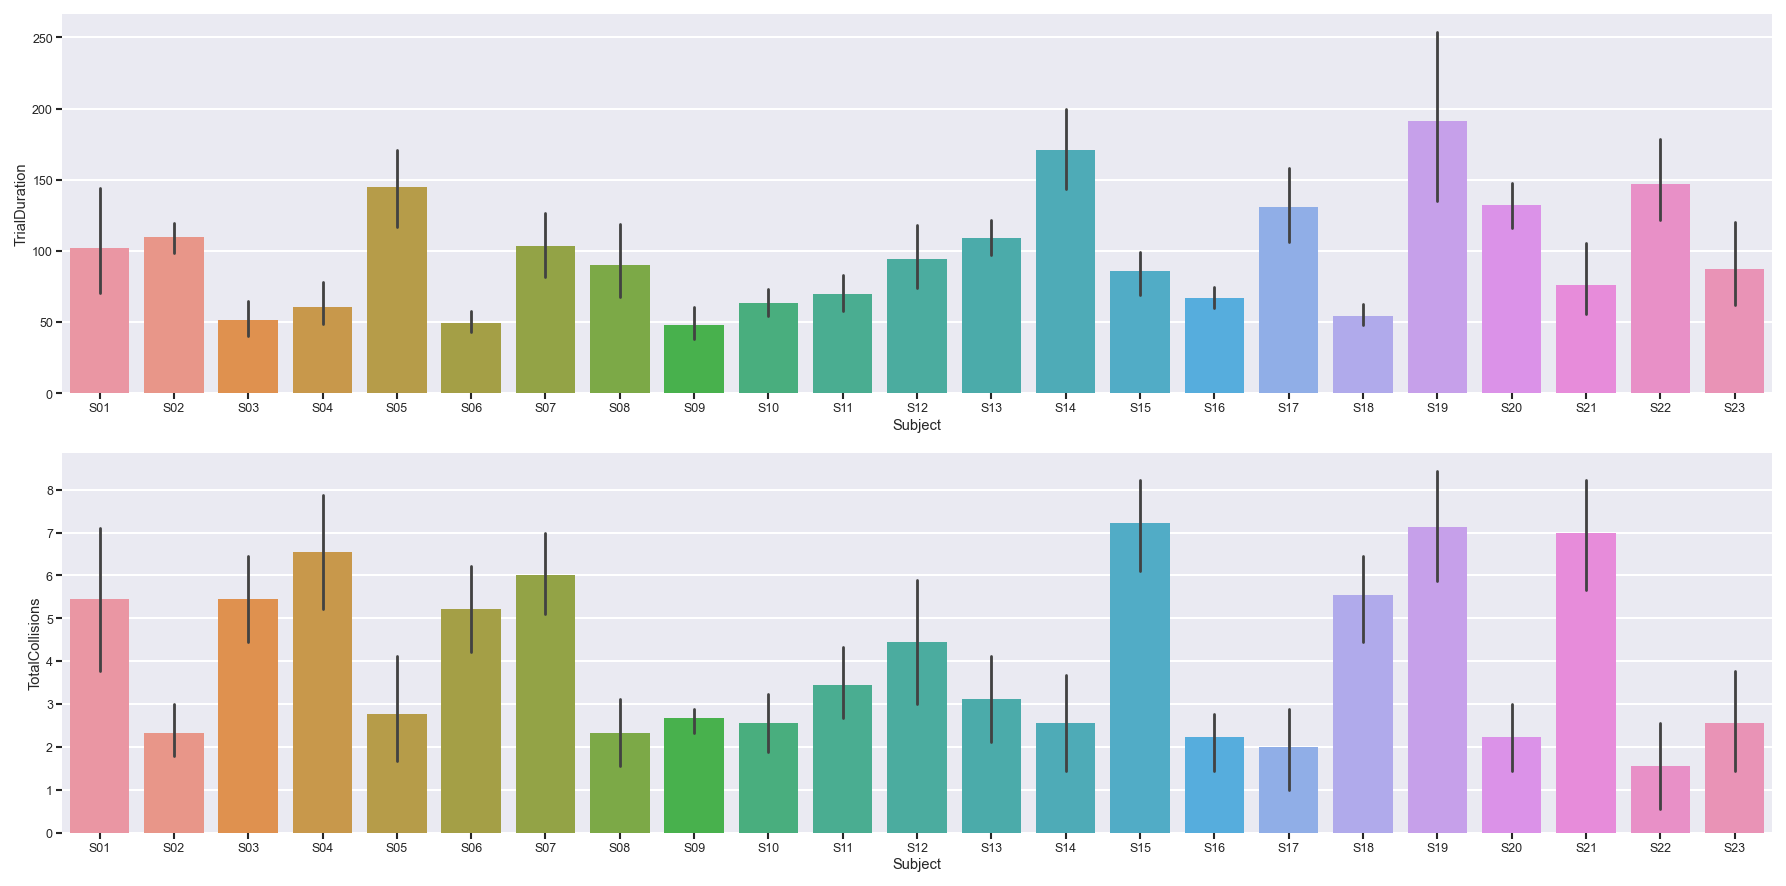

In [12]:
visualization.set_figurestyle()
fig, axs = plt.subplots(2,1, figsize=(12,6), dpi=150)
sns.barplot(data=trial_results, y='TrialDuration', x='Subject', ax=axs[0])
sns.barplot(data=trial_results, y='TotalCollisions', x='Subject', ax=axs[1])
plt.tight_layout()

### Example parcours

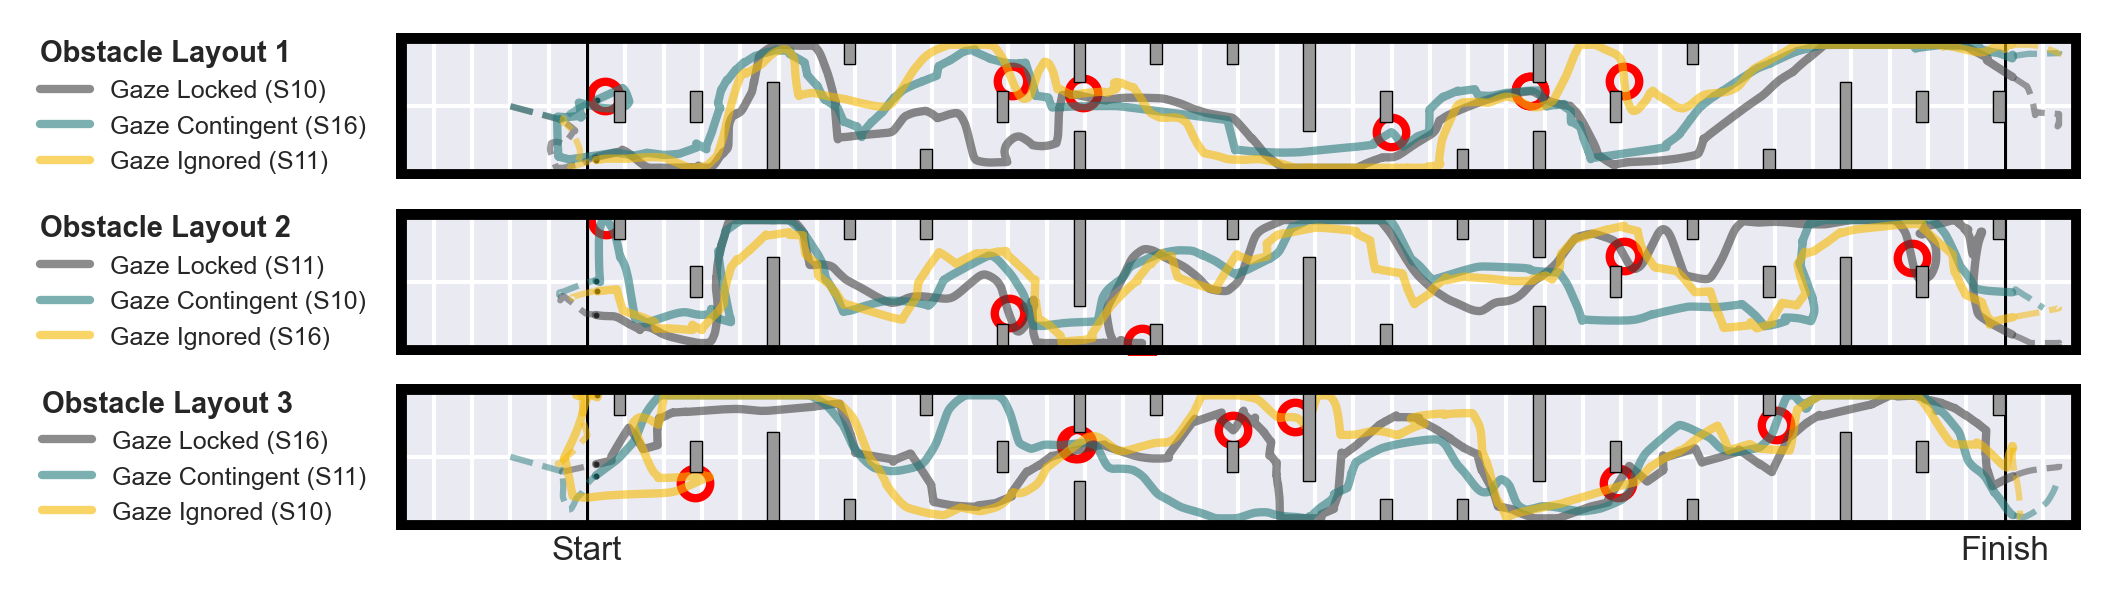

In [13]:
# Activate default figure style
visualization.set_figurestyle()

# Select the example trials to visualize
trials = ['S10B2T0', 'S11B2T2', 'S16B2T2', 'S10B2T1', 'S11B2T0', 'S16B2T0', 'S10B2T2', 'S11B2T1', 'S16B2T1']

# Plot the mobility trajectories
fig, axs = plt.subplots(3,1, figsize = (7.25,2.15), dpi=300)
visualization.plot_mobility_trajectories(data=eng_data_clean, 
                                         trials=trials,
                                         hue='GazeCondition',
                                         cmap=visualization.COLORMAP,
                                         hue_order=visualization.ORDERED_CONDITIONS,
                                         axs = axs)
axs[-1].text(5,-0.1, 'Start', ha='center', va='top', fontsize=8)
axs[-1].text(42,-0.1, 'Finish', ha='center', va='top', fontsize=8)
plt.savefig('out/mobility_trajectories.png', bbox_inches='tight')

## Statistical Analysis

In [14]:
# # In case resuming the analysis from here, uncomment to load previously-saved intermediate results.

# # load per-trial results of mobility analysis 
# trial_results = pd.read_csv('out/mobility_trial_endpoints.tsv',sep='\t')
# trial_results = trial_results.set_index(['TrialIdentifier'])#,'Subject','GazeCondition'])

# # Load validity dataframe (for excluding invalid trials)
# trial_validity = pd.read_csv('out/inclusion_mask.tsv', sep='\t').set_index(['TrialIdentifier'])#,'Subject','GazeCondition'])
# exclusion_criteria = ['InvalidFPS', 'NeverStarted',  'NeverFinished']
# exclusion_mask = trial_validity[exclusion_criteria].any(axis=1)

In [15]:
# Select the relevant variables.
indep_vars = ['Subject', 'Block', 'Hallway', 'GazeCondition'] # The experimental conditions
endpoints = ['TotalCollisions', 'TrialDuration'] # The dependent variables.

# Load the valid 
valid_results = trial_results.loc[~exclusion_mask].reset_index()
print(f'excluding {(exclusion_mask).sum()} trials:')
display(trial_validity.loc[exclusion_mask, exclusion_criteria +['GazeCondition']])

# Average over subjects 
avg = stats.average(valid_results, y=endpoints, group='Subject', x='GazeCondition')

# Normality test
normality = stats.normality_test(avg, endpoints=endpoints)
non_normal_endpoints = [y for y in endpoints if normality.loc['AnyNonNormal', y]]
normal_endpoints = [y for y in endpoints if not normality.loc['AnyNonNormal', y]]
display('Normality test:',  stats.style(normality))

# Non-parametric tests
results_wilcoxon = pd.DataFrame()
if non_normal_endpoints:
    results_wilcoxon = stats.paired_test(avg, group='Subject', endpoints=non_normal_endpoints, test='Wilcoxon')
    # display('Results Wilcoxon:', stats.style(results_wilcoxon, alpha=0.05/3)) # Alpha is corrected for multiple comparisons.

# Parametric tests
results_t_test = pd.DataFrame()
if normal_endpoints:
    results_t_test = stats.paired_test(avg, group='Subject', endpoints=normal_endpoints, test='t-test')
    # display('Results t-test:', stats.style(results_t_test, alpha=0.05/3)) 

# All Results
stat_results = pd.concat([results_wilcoxon, results_t_test], axis=1)[endpoints]
display('Statistical results (merged non-param. + param. tests):', stats.style(stat_results, alpha=0.05/3))

excluding 5 trials:


,InvalidFPS,NeverStarted,NeverFinished,GazeCondition
TrialIdentifier,,,,
S04B1T1,True,False,False,GazeAssistedSampling
S06B2T1,True,False,False,GazeIgnored
S19B0T0,False,False,True,GazeAssistedSampling
S19B2T2,False,False,True,GazeIgnored
S23B0T0,True,False,False,GazeAssistedSampling


'Normality test:'

,TotalCollisions,TrialDuration
GazeAssistedSampling,0.127535,0.072559
GazeIgnored,0.103903,0.007182
SimulationFixedToGaze,0.066901,0.113692
AnyNonNormal,False,True


'Statistical results (merged non-param. + param. tests):'

,TotalCollisions,TrialDuration
Comparison,,
Gaze Locked <> Gaze Contingent,0.014357,0.000639
Gaze Contingent <> Gaze Ignored,0.565486,0.376522
Gaze Locked <> Gaze Ignored,0.000367,0.000738


##### Save output

In [18]:
# Save results
avg.to_csv('out/mobility_analysis_averaged_endpoints.tsv', sep='\t')
normality.to_csv('out/mobility_analysis_normality_test.tsv', sep='\t')
stat_results.to_csv('out/mobility_analysis_paired_testing.tsv', sep='\t')
dfi.export(stat_results, 'out/stats_mobility_analysis.png')

### Visualization

In [19]:
# # In case resuming the analysis from here, uncomment to load previously saved results.
# avg = pd.read_csv('out/mobility_analysis_averaged_endpoints.tsv', sep='\t')
# normality = pd.read_csv('out/mobility_analysis_normality_test.tsv', sep='\t')
# stat_results = pd.read_csv('out/mobility_analysis_paired_testing.tsv', sep='\t').set_index('Comparison')

In [20]:
# Display main results in table format (mean and standard deviation)
display(avg.groupby('GazeCondition')[endpoints].mean())
display(avg.groupby('GazeCondition')[endpoints].std())

# Display significance stars
stars = stat_results.applymap(stats.count_significance_stars)
stars

,TotalCollisions,TrialDuration
GazeCondition,,
GazeAssistedSampling,3.768116,85.862775
GazeIgnored,3.586957,92.085611
SimulationFixedToGaze,4.695652,112.053082


,TotalCollisions,TrialDuration
GazeCondition,,
GazeAssistedSampling,1.969938,32.764165
GazeIgnored,2.124811,44.953342
SimulationFixedToGaze,2.160044,50.722034


,TotalCollisions,TrialDuration
Comparison,,
Gaze Locked <> Gaze Contingent,*,**
Gaze Contingent <> Gaze Ignored,n.s.,n.s.
Gaze Locked <> Gaze Ignored,**,**


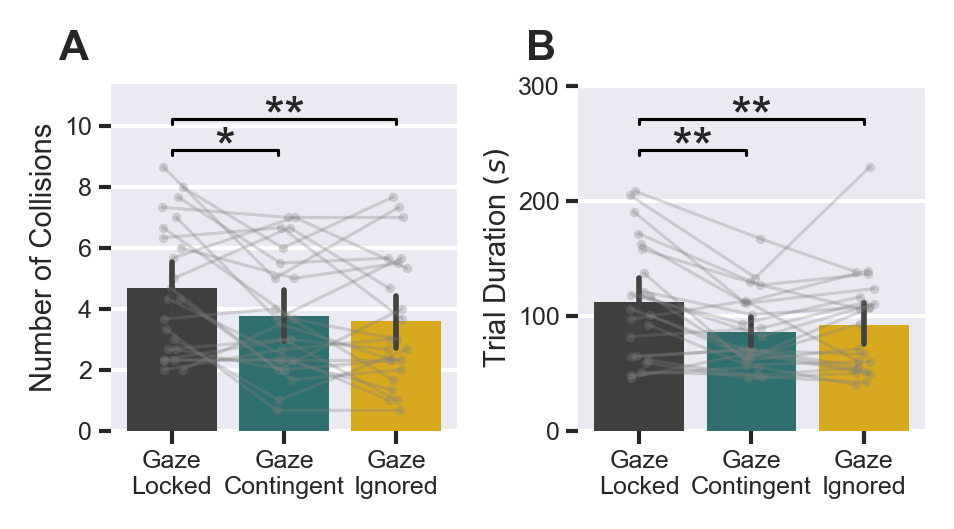

In [21]:
# Set visualization parameters
titles = [None,None]
y_lbls = ['Number of Collisions', 'Trial Duration $(s)$']


visualization.set_figurestyle()

# Plot barplots and overlay swarm plots
fig, axs = visualization.create_subplots(2)
fig,axs = visualization.bar_plots(avg, endpoints, fig=fig,axs=axs)
visualization.swarm_plots(avg, endpoints, group = 'Subject', axs=axs, fig=fig)

# Redefine the x-labels with clean typography  (defaults specified in visualization.py)
visualization.redefine_x_ticks(axs, remove_xlabel=True, new_line=True)

# Add the significance lines
for i, ax in enumerate(axs.flatten()[:len(endpoints)]):
    axs[i].set(title=titles[i],                
               ylabel=y_lbls[i])
    visualization.add_significance_lines(axs[i], stars.replace({'n.s.': None}).iloc[:,i].values,
                               x_pairs=[(0,.95),(1.05,2.),(0,2.)],
                               rel_y=[0.81, 0.81, 0.9],)

# Add the panel indices
visualization.add_panel_index(axs[0], 'A')
visualization.add_panel_index(axs[1], 'B')

# Save the figure
plt.savefig('out/mobility_endpoints.png', bbox_inches = 'tight')